# Multi label Text Classification Snippet Specificity using BERT

## Data Processing

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_excel('3192antibody.xlsx')

In [3]:
dataset.head()

,Row ID,Antibody?,Specificity?,PMID,PMCID,SNIPPET
0,2635,"anti-V5 (RRID:AB_307024), anti-flag (RRID:AB_...",Rabbit Anti-Mouse IgG- positive,27725089,PMC5059142,Input lysates and pulldown eluates were analyz...
1,1744,"""specific antibodies","(positive) ""snippet isnt en/augh to kn/aw what",27506200,PMC4977824,ATAD-3 is an evolutionarily conserved AAA-fami...
2,38,Cy3-conjugated mouse monoclonal antibody speci...,(positive) claim,23468629,PMC3585132,"For ookinete conversion assays, blood was take..."
3,54,this antibody,(positive) claim,24251095,PMC3821019,Rat monoclonal antibody against hKIAA1199 was ...
4,55,"the antibodies specific to KIAA1199, CHC, &#94...",(positive) claim,24251095,PMC3821019,Cell homogenate supernatants were separated by...


### Remove redundant information

In [4]:
dataset.drop('Antibody?',axis=1,inplace=True)
dataset.drop('PMID',axis=1, inplace=True)
dataset.drop('PMCID',axis=1,inplace=True)

### How many specificity class right now?

In [5]:
import matplotlib.pyplot as plt

In [6]:
specificity_cases = dict()
count_record = 0

In [7]:
for value in dataset['Specificity?']:
    if pd.isna(value) == False:
        v = value.strip('\n')
        v = v.strip()
        specificity_cases[v] = specificity_cases.get(v, 0) + 1
        count_record += 1

In [8]:
specificity_cases

{'Rabbit Anti-Mouse IgG- positive': 1,
 '(positive) "snippet isnt en/augh to kn/aw what': 1,
 '(positive) claim': 3,
 '2 positive, 2 claim positive': 1,
 'antibody pennetration method': 1,
 'claim': 19,
 'claim (positive)': 2,
 'Claim +ve': 3,
 'claim positive': 217,
 'Claim positive': 2,
 'claim positive, claim nonspecific': 1,
 'claim positive, claim nonspecific, claim positive': 1,
 'claim positive, N/A': 1,
 'claim positive, n/anspecific': 2,
 'claim positive, nonspecific, positive(3)': 1,
 'claim positive, positive.': 2,
 'Claim positive(2), nonspecific (2)': 1,
 'claim postive': 2,
 'claim, positive': 1,
 'Clzim positive': 1,
 'N/A': 3,
 'N/A, Claim positive(2)': 1,
 'N/A, negative': 2,
 'N/A, positive': 3,
 'N/A?': 2,
 'N/A(2), claim positive(2)': 1,
 'n/anspecfic': 1,
 'n/anspecific': 11,
 'n/anspecific (2)  positive': 2,
 'n/anspecific, rest are claim positive': 1,
 'n/at sure': 10,
 'na': 12,
 'negative': 96,
 'negative, N/A': 1,
 'negative, neutral': 1,
 'netural': 1,
 'netu

In [9]:
count_record

2431

Try redunce these cases into 5 labels classes

In [10]:
fivecases = dict()

In [11]:
for key in specificity_cases:
    s = " "
    for k in key.split(' '):
        if "neg" in k or "unspecific" in k or "nonspecific" in k:
            s = s + "negative "
        elif "neu" in k or "netural" in k:
            s = s + "neural "
        elif "unsure" in k or "not sure" in k:
            s = s + "unsure "
        elif "claim" in k or "Claim" in k or "Clzim" in k:
            s = s + "claim "
        elif "pos" in k or "+ve" in k:
            s = s + "positive "
        elif "na" in k or "N/A" in k or "n/a" in k:
            s = s + "unsure "
    s = s.strip()
    fivecases[s] = fivecases.get(s, 0) + 1

In [12]:
fivecases

{'positive': 9,
 'positive unsure unsure': 1,
 'positive claim': 2,
 'positive claim positive': 2,
 '': 6,
 'claim': 1,
 'claim positive': 8,
 'claim positive claim negative': 1,
 'claim positive claim negative claim positive': 1,
 'claim positive unsure': 2,
 'claim positive negative positive': 1,
 'claim positive positive': 1,
 'claim positive negative': 1,
 'unsure': 9,
 'unsure claim positive': 3,
 'unsure negative': 1,
 'unsure positive': 3,
 'negative': 5,
 'negative unsure': 1,
 'negative neural': 1,
 'neural': 3,
 'neural claim positive': 1,
 'negative positive': 1,
 'positive unsure': 3,
 'positive neural': 2,
 'positive negative': 4,
 'unsure positive negative': 1,
 'unsure unsure unsure': 1}

In [13]:
LABELS_COLUMN = ["positive", "negative", "neutral", "unsure", "claim"]

In [14]:
def labels_to_onehot(labels):
    onehot = [0, 0, 0, 0, 0]
    
    for k in labels.split(' '):
        if "neg" in k or "unspecific" in k or "nonspecific" in k:
            onehot[1] = 1
        elif "neu" in k or "netural" in k:
            onehot[2] = 1
        elif "unsure" in k or "not sure" in k:
            onehot[3] = 1
        elif "claim" in k:
            onehot[4] = 1
        elif "pos" in k or "+ve" in k:
            onehot[0] = 1
        elif "na" in k or "N/A" in k or "n/a" in k:
            onehot[3] = 1
    if len(set(onehot)) == 0:
        onehot[3] = 1
    return onehot

In [28]:
def onehot_to_labels(onehot):
    labels = ","
    
    for o in range(len(onehot)):
        if onehot[o] == 1:
            labels += LABELS_COLUMN[o] + ","
            
    return labels.strip(',')

### Reconstruct Dataset

In [29]:
import csv

In [30]:
with open('dataset.csv', mode='w') as csv_file:
    fieldnames = ['snippet', 'positive', 'negative', 'neutral', 'unsure', 'claim']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for index, row in dataset.iterrows():
        label = row['Specificity?']
        if pd.isna(row['Specificity?']) == False:
            onehot = labels_to_onehot(label)
            writer.writerow({
                'snippet': row['SNIPPET'], 
                'positive': onehot[0], 
                'negative': onehot[1], 
                'neutral': onehot[2],
                'unsure': onehot[3],
                'claim': onehot[4]
            })

In [31]:
with open('for_distribution.csv', mode='w') as file:
    fieldnames = ['snippet', 'labels']
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()
    for index, row in dataset.iterrows():
        label = row['Specificity?']
        if pd.isna(row['Specificity?']) == False:
            onehot = labels_to_onehot(label)
            labels = onehot_to_labels(onehot)
            writer.writerow({
                'snippet': row['SNIPPET'], 
                'labels': labels
            })

### Dataset distribution

In [32]:
df = pd.read_csv('for_distribution.csv')
df.head()

,snippet,labels
0,Input lysates and pulldown eluates were analyz...,positive
1,ATAD-3 is an evolutionarily conserved AAA-fami...,"positive,unsure"
2,"For ookinete conversion assays, blood was take...","positive,claim"
3,Rat monoclonal antibody against hKIAA1199 was ...,"positive,claim"
4,Cell homogenate supernatants were separated by...,"positive,claim"


In [35]:
target_count = df.labels.value_counts()
target_count

positive                    1585
positive,claim               283
neutral                      241
negative                     143
unsure                       112
claim                         19
positive,unsure               13
positive,negative             12
positive,unsure,claim          5
negative,unsure                3
positive,negative,claim        3
positive,neutral               2
positive,neutral,claim         1
positive,negative,unsure       1
negative,neutral               1
Name: labels, dtype: int64

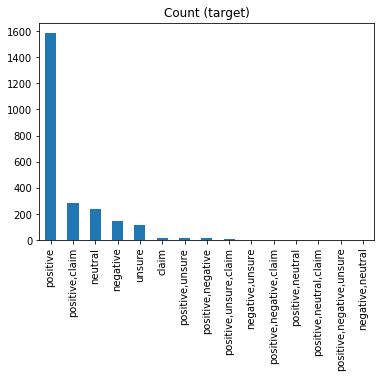

In [36]:
target_count.plot(kind='bar', title='Count (target)');

### Test Set

In [39]:
with open('testset.csv', mode='w') as csv_file:
    fieldnames = ['id', 'snippet']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for index, row in dataset.iterrows():
        label = row['Specificity?']
        if pd.isna(row['Specificity?']) == True:
            writer.writerow({
                'id': row['Row ID'],
                'snippet': row['SNIPPET'], 
            })

In [40]:
df = pd.read_csv('testset.csv')
df.head()

,id,snippet
0,594,"Alpha-sma is also expressed on MM, but areas o..."
1,656,Successful universal IAV vaccines not only ind...
2,657,"These cells, via perforin dependent cytotoxici..."
3,701,Normal tonsil and bone marrow was used as posi...
4,729,VectaShield mounting medium was applied and co...
